Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import datetime
from catboost import CatBoostRegressor
from catboost.utils import eval_metric
from sklearn.dummy import DummyRegressor
import xgboost as xgb

In [2]:
autos = pd.read_csv('datasets/autos.csv')

In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


В части данных есть пропуски. Обобщим информацию о них:

In [5]:
autos.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Здесь стоит отметить, что пропуски носят разный характер. Так, в столбце NotRepaired не можем заполнить их каким-либо образом, так как пропуски носят неслучайный характер - признак "была в ремонте" индивидуален для каждой конкретной машины, а признак критичный - придется отбросить пропуски. В то же время как такие колонки, как VehicleType, Gearbox и FuelType могут быть заполнены значениями, взятыми из записей об автомобилей той же модели с похожими характеристиками. Для этого можно попробовать KNN Imputer. 

По столбцу "Модель" данные тоже лучше отбросить, могут быть машины с похожим пробегом и годом выпуска, тут лучше не угадывать

In [6]:
autos.dropna(subset=['NotRepaired', 'Model'], inplace=True)

In [7]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,272564.000000,272564.000000,272564.000000,272564.000000,272564.000000,272564.0,272564.000000
mean,4914.249703,2003.547640,116.698995,127726.552296,6.072629,0.0,51148.739749
std,4658.004959,30.934818,161.194646,37015.341073,3.546299,0.0,25845.458707
min,0.000000,1600.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30826.000000
50%,3250.000000,2004.000000,109.000000,150000.000000,6.000000,0.0,50226.000000
75%,7000.000000,2008.000000,147.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Минимальная цена 0 - странно.
- Минимальный год регистрации - 1000, такого точно быть не может. 
- Минимальная мощность 0 - машина не на ходу или просто ошибка? Скорее второе.
- Минимальный месяц регистрации 0 - можно предположить, что считают с 0 до 11, но максимальный месяц 12 - скорее нет. Данный признак вообще вряд ли важен для обучения - отбросим. 
- Количество фотографий - ноль вообще везде. Отбрасываем.
- Почтовый код - однозначно отбрасываем.
- DateCrawled - отбрасываем, признак связан с объявлением, а не с автомобилем
- LastSeen - отбрасываем по той же причине

In [8]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58


Отбрасываем однозначно бесполезные признаки

In [9]:
DateCreated = pd.to_datetime(autos.loc[:, 'DateCreated']) # это пригодится дальше

In [10]:
autos.drop(['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated'], axis=1, inplace=True)

Попробуем заполнить пропуски через KNN Imputer

In [11]:
# have_nans = ['VehicleType', 'Gearbox', 'FuelType']

В процессе выполнения выяснилось, что KNN не работает с категориальными признаками, и нужно кодирование. В свою очередь, OrdinalEncoder не работает с пропусками. По моему прошлому опыту, заполнение пропусков не оказывает большого влияния на модель, и проще все отбросить. Безусловно, это существенная часть данных, однако мы уже были вынуждены отбросить пропуски в колонке NotRepaired, а в ней было наибольшее количество пропусков.

Тем не менее, я решил попробовать KNN по достаточно громоздкой схеме. Итак, первым делом заполняем пропуски выбранным значением

In [12]:
# autos.fillna('unknown', inplace=True)

Теперь переводим категориальные признаки в числовой формат

In [13]:
# encoder = OrdinalEncoder()
# autos.loc[:, autos.dtypes == 'object'] = encoder.fit_transform(autos.loc[:, autos.dtypes == 'object'])

Теперь можно бы использовать KNN, предварительно заменив unknown обратно на np.nan, но его тоже закодировали, так что применяем такой костыль: смотрим, как именно закодировались признаки, затем вручную меняем числа на пропуски

In [14]:
# encoder.categories_

In [15]:
# autos.loc[:, 'VehicleType'] = autos.loc[:, 'VehicleType'].replace(7, np.nan)
# autos.loc[:, 'Gearbox'] = autos.loc[:, 'Gearbox'].replace(2, np.nan)
# autos.loc[:, 'FuelType'] = autos.loc[:, 'FuelType'].replace(7, np.nan)

Теперь impute. Он в ходе экспериментов оказался НЕМНОГО лучше (но лучше), чем SimpleImputer (мода или среднее) или выбрасывание вообще всех подряд пропусков

**v2** __*Теперь использую преобразование типов вместо предыдущей схемы!*__

In [16]:
autos.dtypes

Price                int64
VehicleType         object
RegistrationYear     int64
Gearbox             object
Power                int64
Model               object
Kilometer            int64
FuelType            object
Brand               object
NotRepaired         object
dtype: object

In [17]:
autos.fillna('nan', inplace=True)

In [18]:
autos_copy = autos.copy() # это для кодировщика ниже..

In [19]:
autos.loc[:, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']] = \
autos.loc[:, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']].astype('category')
autos.loc[:, 'NotRepaired'] = autos.loc[:, 'NotRepaired'].astype('bool')

In [20]:
# knn = KNNImputer(n_neighbors=4)
# knn.fit(autos)

Тут столкнулся с проблемой нехватки памяти (винда берется делать, но скорость просто никакая, линукс хочет 64 гига под эту операцию), слишком большая матрица получается, ограничение смог обойти, обрабатывая данные по кускам.

В функцию встроил небольшой таймер, показывает, сколько времени примерно осталось

In [21]:
# start = datetime.datetime.now()
# i = 0
# while True: 
#     if i < autos.shape[0]:
#         autos.iloc[i:i+5000, :] = knn.transform(autos.iloc[i:i+5000, :])
#         elapsed = (datetime.datetime.now() - start).seconds
#         parsed = i + 5000
#         clear_output()
#         print(f'Осталось {autos.shape[0] - parsed} строк')
#         print(f'Ждем еще около {(autos.shape[0] - parsed) // (parsed / elapsed)} секунд!')
#         i += 5000
#     else:
#         i -=5000
#         autos.iloc[i:autos.shape[0], :] = knn.transform(autos.iloc[i:autos.shape[0], :])
#         clear_output()
#         print(f'Посчитались за {(datetime.datetime.now() - start).seconds} секунд')
#         break

**v2** решил я избавиться от этого метода, он с категориальными признаками тоже не завелся, а кодировать ради KNN и декодировать обратно для обучения моделей показалось слишком сложным. к тому же KNN очень долго отрабатывал

In [22]:
autos.dtypes

Price                  int64
VehicleType         category
RegistrationYear       int64
Gearbox             category
Power                  int64
Model               category
Kilometer              int64
FuelType            category
Brand               category
NotRepaired             bool
dtype: object

<AxesSubplot:>

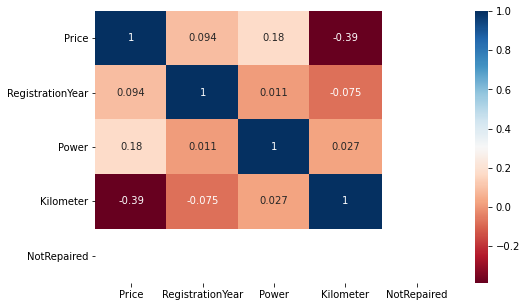

In [23]:
plt.figure(figsize=(8,5))
sns.heatmap(autos.corr(), cmap='RdBu', cbar=True, annot=True)

Видно, что сильнее всего на цену влияет километраж, тип топлива и КПП, а также факт того, была ли машина в ремонте (т.е. не зря выбросили пропуски по ремонту)

**v2** теперь не очень-то видно, остались только количественные признаки, ну да ладно

Еще раз обобщим количественные данные:

In [24]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer
count,272564.000000,272564.000000,272564.000000,272564.000000
mean,4914.249703,2003.547640,116.698995,127726.552296
std,4658.004959,30.934818,161.194646,37015.341073
min,0.000000,1600.000000,0.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,3250.000000,2004.000000,109.000000,150000.000000
75%,7000.000000,2008.000000,147.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Уберем экстремальные значения. Начнем с года регистрации, здесь присутствуют как неправдоподобно низкие (1000), так и неправдоподобно высокие (9999) значения. Чтобы не "прицеливаться" вручную, уберем верхние и нижние полпроцента

In [25]:
autos = autos.query('RegistrationYear.quantile(0.005) < RegistrationYear < RegistrationYear.quantile(0.995)')

Теперь то же самое сделаем со столбцом Power. Очевидно, что машин с нулевой мощностью двигателя не может быть в принципе, как и с 20000 л.с. Также уберем по 0.5% с каждой стороны

In [26]:
autos = autos.query('Power.quantile(0.005) < Power < Power.quantile(0.995)')

In [27]:
autos.reset_index(inplace=True, drop=True)

На данном датасет уже готов к построению модели. Датасет несколько "похудел" за время предобработки, однако это было скорее всего неизбежно. Остался лишь столбец с целевым признаком. Его распределение выглядит так:

<AxesSubplot:xlabel='Price'>

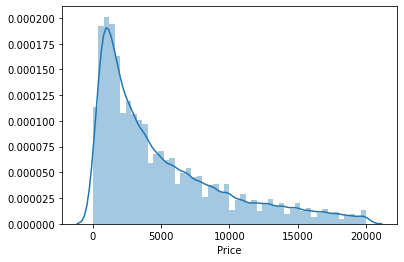

In [28]:
sns.distplot(autos.Price)

Мы видим достаточно большой хвост около нуля, непонятно, ошибка это или нет, но если их убрать, качество модели улучшится ненамного, поэтому пусть остается, возможно, продается автохлам, цены указаны в евро, в принципе, убитые жигули можно и за 200 евро найти

Но вообще в реальной задаче стоило бы уточнить происхождение данных, может, там какая-то обналичка идет или еще чего, поэтому так много низких цен.

# 2. Обучение моделей

Указываем таргет, делим выборки

In [29]:
features = autos.drop('Price', axis=1)
target = autos['Price']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=9)

In [31]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (188566, 9)
y_train (188566,)
X_test (62856, 9)
y_test (62856,)


Начнем с обычной линейной регрессии, чтобы было с чем сравнивать

### Линейная регрессия

**v2** линейная регрессия и лес не работают с категориальными фичами, пришлось создавать отдельный набор трейн/тест с кодировкой категориальных признаков

Кроме того, не удавалось зафитить кодировщик на трейне и потом использовать этот же кодировщик для трансформации фич в тесте. Пришлось переводить данные обратно к dtype object

In [32]:
autos_copy = autos.copy()
autos_copy.loc[:, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']] = \
autos_copy.loc[:, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']].astype('object')

In [33]:
encoder = OrdinalEncoder()
autos_copy = pd.DataFrame(encoder.fit_transform(autos_copy), columns=autos_copy.columns)

In [34]:
features_copy = autos_copy.drop('Price', axis=1)
target_copy = autos_copy['Price']
X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(features_copy, target_copy, random_state=9)

In [53]:
print('X_train', X_train_sklearn.shape)
print('y_train', y_train_sklearn.shape)
print('X_test', X_test_sklearn.shape)
print('y_test', y_test_sklearn.shape)

X_train (188566, 9)
y_train (188566,)
X_test (62856, 9)
y_test (62856,)


In [35]:
lin1 = LinearRegression()
cross_val_score(lin1, X_train_sklearn, y_train, scoring='neg_root_mean_squared_error')

array([-2972.78068897, -2991.48988781, -2993.44462654, -2982.38311133,
       -2998.15888212])

(масштабирование изменений не дало) 

Попробуем еще модель случайного леса (тоже ведь ансамбль)

### Случайный лес

In [36]:
forest = RandomForestRegressor(max_depth=10)
cross_val_score(forest, X_train_sklearn, y_train, scoring='neg_root_mean_squared_error')

array([-1894.10136713, -1915.69325619, -1909.64825903, -1917.84747949,
       -1929.82553701])

Лучше, чем линейная регрессия, но и обучается дольше. Теперь перейдем к бустингу

### Модель бустинга LightGBM

Модели LGBM. Не нашел в библиотеке аналога GridSearch, можно было сделать перебор гиперпараметров, используя циклы, либо попробовать скрестить модель регрессии LGBM с GridSearch из sklearn, я выбрал второе

In [37]:
model = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth': np.arange(1, 11, 2),
    'verbose': [-1],      # спамит сообщениями, если не указать
    'num_leaves': [40],   # ругается, если не выставить этот параметр
    'n_estimators': [50, 100, 300],
}

cv = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [38]:
%%time
cv.fit(X_train, y_train)

Wall time: 6min 11s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': array([1, 3, 5, 7, 9]),
                         'n_estimators': [50, 100, 300], 'num_leaves': [40],
                         'verbose': [-1]},
             scoring='neg_root_mean_squared_error')

In [39]:
cv.best_score_

-1649.2784960140932

In [40]:
cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 9,
 'n_estimators': 300,
 'num_leaves': 40,
 'verbose': -1}

### Модель бустинга CatBoost

In [41]:
%%time
cat_model = CatBoostRegressor(cat_features=[column for column in autos.columns \
                                            if autos[column].dtype not in ['int64','bool']] )
                                            # иначе TypeError: data type 'category' not understood ¯\_(ツ)_/¯
cats_gs = cat_model.grid_search({'learning_rate': np.arange(0.1, 1, 0.6),
                                 'depth': np.arange(1, 11, 2), 'n_estimators': [50, 100, 300]}, X_train, y_train)


bestTest = 2737.338057
bestIteration = 49

0:	loss: 2737.3380571	best: 2737.3380571 (0)	total: 757ms	remaining: 22s

bestTest = 2357.466189
bestIteration = 49

1:	loss: 2357.4661885	best: 2357.4661885 (1)	total: 1.3s	remaining: 18.2s

bestTest = 2432.440468
bestIteration = 99

2:	loss: 2432.4404683	best: 2357.4661885 (1)	total: 2.29s	remaining: 20.6s

bestTest = 2286.439262
bestIteration = 99

3:	loss: 2286.4392622	best: 2286.4392622 (3)	total: 3.27s	remaining: 21.2s

bestTest = 2273.618755
bestIteration = 299

4:	loss: 2273.6187549	best: 2273.6187549 (4)	total: 5.97s	remaining: 29.8s

bestTest = 2229.648532
bestIteration = 299

5:	loss: 2229.6485321	best: 2229.6485321 (5)	total: 8.8s	remaining: 35.2s

bestTest = 2162.03781
bestIteration = 49

6:	loss: 2162.0378096	best: 2162.0378096 (6)	total: 9.55s	remaining: 31.4s

bestTest = 1964.971181
bestIteration = 49

7:	loss: 1964.9711814	best: 1964.9711814 (7)	total: 10.4s	remaining: 28.5s

bestTest = 2037.74007
bestIteration = 99

8:	loss:

In [42]:
print(cats_gs['params'])

{'depth': 9, 'iterations': 300, 'learning_rate': 0.1}


### Модель XGBoost

In [43]:
xmodel = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=8)
x_param_grid = {
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth': np.arange(1, 11, 2),
    'n_estimators': [50, 100, 300],
}

xcv = GridSearchCV(xmodel, x_param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [44]:
%%time
xcv.fit(X_train_sklearn, y_train)

Wall time: 25min 9s


GridSearchCV(cv=5,
             estimator=XGBRegressor(n_jobs=8, objective='reg:squarederror'),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': array([1, 3, 5, 7, 9]),
                         'n_estimators': [50, 100, 300]},
             scoring='neg_root_mean_squared_error')

In [45]:
xcv.best_score_

-1641.9839035237237

# 3. Анализ моделей

Обучим модели с оптимальными гиперпараметрами и сравним скорость обучения

In [46]:
results={}

### Модель бустинга LightGBM

In [47]:
lgb_final = lgb.LGBMRegressor(**cv.best_params_)
start_train = datetime.datetime.now()
lgb_final.fit(X_train, y_train)
end_train = datetime.datetime.now()
start_pred = datetime.datetime.now()
lgb_pred = lgb_final.predict(X_test)
end_pred = datetime.datetime.now()
lgb_score = eval_metric([y_test], [lgb_pred], 'RMSE')
results['LightGBM'] = [(end_train-start_train).seconds, (end_pred-start_pred).microseconds//1000, int(*lgb_score)]

### Модель бустинга CatBoost

In [48]:
cat_final = CatBoostRegressor(**cats_gs['params'], cat_features=[column for column in autos.columns \
                                                if autos[column].dtype not in ['int64','bool']] )
start_train = datetime.datetime.now()
cat_final.fit(X_train, y_train)
end_train = datetime.datetime.now()
start_pred = datetime.datetime.now()
cat_pred = cat_final.predict(X_test)
end_pred = datetime.datetime.now()
cat_score = eval_metric([y_test], [cat_pred], 'RMSE')
results['CatBoost'] = [(end_train-start_train).seconds, (end_pred-start_pred).microseconds//1000, int(*cat_score)]
clear_output()

### Модель бустинга XGBoost

In [50]:
xgb_final = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=8, **xcv.best_params_)
start_train = datetime.datetime.now()
xgb_final.fit(X_train_sklearn, y_train)
end_train = datetime.datetime.now()
start_pred = datetime.datetime.now()
xgb_pred = xgb_final.predict(X_test_sklearn)
end_pred = datetime.datetime.now()
xgb_score = eval_metric([y_test], [xgb_pred], 'RMSE')
results['XGBoost'] = [(end_train-start_train).seconds, (end_pred-start_pred).microseconds//1000, int(*xgb_score)]

### Итоговая таблица

In [51]:
pd.DataFrame(results, index=['Время обучения, с', 'Время предсказания, мс', 'RMSE (тест)'])

,LightGBM,CatBoost,XGBoost
"Время обучения, с",1,43,9
"Время предсказания, мс",170,106,259
RMSE (тест),1647,1685,1645


**v2** Первая модель обучается в несколько раз быстрее, однако CatBoost делает предсказания быстрее. Стоит уточнить у заказчика ожидаемый объем нагрузки на готовую модель. В случае высоконагруженной системы с большим потоком клиентов может быть целесообразнее потратить больше времени на обучение, но в процессе работы быстрее отдавать результат (хотя это лишь мое предположения, я модели в продакшн не запускал, не знаю, как там оно). XGBoost учится быстрее CatBoost, но дает худшее время вредсказания (хотя RMSE в итоге получился очень неплохой). 

### Проверка на адекватность

In [52]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dum_pred = dummy.predict(X_test)
eval_metric([y_test], [dum_pred], 'RMSE')

[4663.278400768442]

## Общий вывод

В ходе выполнения проекта была разработана модель для предсказания цены автомобиля исходя из его параметров. В ходе предобработки данных были исключены наблюдения с отсутствующими данными о факте ремонта автомобиля, поскольку данный показатель является критичным для многих покупателей. Пропуски в остальных признаках были заполнены по принципу ближайших соседей. Также были исключены из выборки строки с экстремальными (неадекватными) значениями признаков.

Далее при помощи кросс-валидации и автоматического перебора гиперпараметров выбрали оптимальную модель. Поскольку результаты моделей из двух разных библиотек оказались схожими, трудно принять однозначное решение, склоняюсь к первой модели, LightGBM, поскольку эта модель представляет наилучший компромисс между точностью и скоростью обучения и предсказаний, однако в ситуации, когда критически важна скорость именно предсказания, может быть более полезно применить модель из CatBoost (тут нужно уточнять у заказчика).

На финальном этапе проверили качество предсказаний модели на тестовой выборке, также модель успешно прошла проверку на адекватность.